# **💁🏻🗨️💁🏻‍♂️안개 예측 EDA code**
> **안개량 예측** 경진대회에 오신 여러분 환영합니다! 🎉    
> 본 대회에서는 최대 10명이 참여할 수 있는 기상청 주관 날씨 빅데이터 경진대회 입니다.     
> 주어진 데이터를 활용하여 안개 상태의 구간을 예측할 수 있는 모델을 만드는 것이 목표입니다!

# Contents  
  
- 필요한 라이브러리 설치  
- 데이터 불러오기 (KNN) 
- 데이터 EDA

### 1. 필요한 라이브러리 설치

- 필요한 라이브러리를 설치한 후 불러옵니다.

In [1]:
# basic
import os, random
import pandas as pd
import numpy as np

# graph
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# imputator
from sklearn.impute import KNNImputer

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 폰트
plt.rcParams['font.family'] = 'NanumSquare'

# 마이너스 출력
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
# random seed 고정하기
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

### 2. 데이터 불러오기
- 제공된 데이터를 불러옵니다.

> - year : 년도
> - month : 월
> - day : 일
> - hour : 시간
> - minute : 분(10분 단위)
> - stn_id : 지점 번호
> - ws10_deg : 10분 평균 풍향, deg
> - ws10_ms : 10분 평균 풍속, m/s
> - ta : 1분 평균 기온 10분 주기, 섭씨
> - re : 강수 유무 0:무강수, 1:강수
> - hm : 1분 평균 상대 습도 10분 주기, %
> - sun10 : 1분 일사량 10분 단위 합계, MJ
> - ts : 1분 평균 지면온도 10분 주기, 섭씨

- test 없는 데이터 값
> - vis1 : 1분 평균 시정 10분 주기, m
> - class : 시정 구간

시정 구간은 다음과 같다.
- 0초과 200미만 : 1
- 200이상 500미만 : 2
- 500이상 1000미만 : 3
- 1000이상 : 4
- 4번은 맞춰도 스코어가 증가하진 않지만 틀리면 감점

In [3]:
# load makes data
train_knn = pd.read_csv('../data/train_knnimputer.csv')
test_knn = pd.read_csv('../data/test_knnimputer.csv')

### 3. 데이터 EDA

#### 시간적 사이클

- 계절에 따른 차이가 존재할 수 있기 때문에 계절에 관한 사이클을 만들어 주도록 하자
- 하루 단위로 온도의 변화가 존재하기 때문에 이를 학습시키기 위해 하루 단위를 변화하도록 하자

In [4]:
# 시간 사이클 변수
train_knn['sin_time'] = np.sin(2 * np.pi * train_knn['time'] / 24)
train_knn['cos_time'] = np.cos(2 * np.pi * train_knn['time'] / 24)

test_knn['sin_time'] = np.sin(2 * np.pi * test_knn['time'] / 24)
test_knn['cos_time'] = np.cos(2 * np.pi * test_knn['time'] / 24)

In [5]:
# 계절 사이클 변수 - 월별 주기
train_knn['sin_month'] = np.sin(2 * np.pi * train_knn['month'] / 12)
train_knn['cos_month'] = np.cos(2 * np.pi * train_knn['month'] / 12)

test_knn['sin_month'] = np.sin(2 * np.pi * test_knn['month'] / 12)
test_knn['cos_month'] = np.cos(2 * np.pi * test_knn['month'] / 12)

In [6]:
# 이전 class
train_knn['class_before'] = train_knn['class'].shift(1)
train_knn['class_before'][train_knn['class_before'].isna()] = train_knn['class'][train_knn['class_before'].isna()]

In [7]:
# fog
cri = [
    (train_knn['class'] == 4) & (train_knn['class_before'] != 4),
    (train_knn['class'] != 4) & (train_knn['class_before'] == 4)
]
con = [
    -1, 1
]
train_knn['fog'] = np.select(cri, con, default = 0)

In [8]:
# 안개발생 시작 시점
fog = train_knn[train_knn['fog'] == 1].reset_index(drop = True)

In [9]:
# 안개 발생 종료시점을 추가
fog['EndDateTime'] = train_knn[train_knn['fog'] == -1]['DateTime'].reset_index(drop = True)

In [10]:
# 날짜 데이터로 바꾸기
fog['DateTime'] = pd.to_datetime(fog['DateTime'])
fog['EndDateTime'] = pd.to_datetime(fog['EndDateTime'])

In [11]:
# 안개 지속시간 구하기
fog['last_fog'] = (fog['EndDateTime'] - fog['DateTime']).dt.seconds/3600

In [12]:
# 이제부터 시각화를 시작하지
fig = px.histogram(fog,
                  x = "month",
                  color='ground',
                  barmode="group")

fig.update_layout(title_text="월별 안개발생 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

<AxesSubplot: xlabel='last_fog', ylabel='Count'>

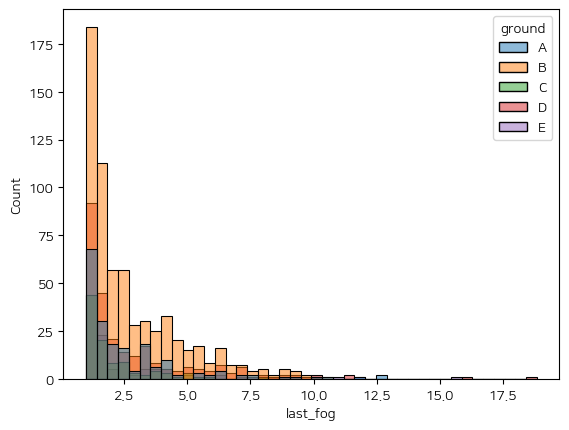

In [13]:
# 1시간 이상 지속시간 분포도
sns.histplot(fog[fog['last_fog'] >= 1], x = 'last_fog', hue = 'ground')

In [14]:
# 1시간 이상만 모아서
fig = px.histogram(fog[fog['last_fog'] >= 1],
                  x = "month",
                  color='ground',
                  barmode="group")

fig.update_layout(title_text="월별 안개발생 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [15]:
# 1시간 미만
fig = px.histogram(fog[fog['last_fog'] < 1],
                  x = "month",
                  color='ground',
                  barmode="group")

fig.update_layout(title_text="월별 안개발생 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [16]:
# 1시간 이상만 모아서
fig = px.histogram(fog[fog['last_fog'] >= 1],
                  x = "hour",
                  color='ground',
                  barmode="group")

fig.update_layout(title_text="시간대별 안개발생 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [17]:
# 1시간 미만
fig = px.histogram(fog[fog['last_fog'] < 1],
                  x = "hour",
                  color='ground',
                  barmode="group")

fig.update_layout(title_text="시간대별 안개발생 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [18]:
fog['class_before'].value_counts()

4.0    7541
Name: class_before, dtype: int64

In [19]:
# 안개발생 종료 시점
fog2 = train_knn[train_knn['fog'] == -1].reset_index(drop = True)

In [20]:
# 안개 발생 시작시점을 추가
fog2['StartDateTime'] = train_knn[train_knn['fog'] == 1]['DateTime'].reset_index(drop = True)

In [21]:
# 날짜 데이터로 바꾸기
fog2['DateTime'] = pd.to_datetime(fog2['DateTime'])
fog2['StartDateTime'] = pd.to_datetime(fog2['StartDateTime'])

In [22]:
# 안개 지속시간 구하기
fog2['last_fog'] = (fog2['DateTime'] - fog2['StartDateTime']).dt.seconds/3600

In [23]:
# 1시간 이상만 모아서
fig = px.histogram(fog2[fog2['last_fog'] >= 1],
                  x = "month",
                  color='ground',
                  barmode="group")

fig.update_layout(title_text="월별 안개발생 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [24]:
# 1시간 미만
fig = px.histogram(fog2[fog2['last_fog'] < 1],
                  x = "month",
                  color='ground',
                  barmode="group")

fig.update_layout(title_text="월별 안개발생 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [25]:
# 1시간 이상만 모아서
fig = px.histogram(fog2[fog2['last_fog'] >= 1],
                  x = "hour",
                  color='ground',
                  barmode="group")

fig.update_layout(title_text="시간대별 안개발생 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [26]:
# 1시간 미만
fig = px.histogram(fog2[fog2['last_fog'] < 1],
                  x = "hour",
                  color='ground',
                  barmode="group")

fig.update_layout(title_text="시간대별 안개발생 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [27]:
# 1시간 이상만 모아서
fig = px.histogram(fog[fog['last_fog'] >= 1],
                  x = "month")

fig.update_layout(title_text="월별 안개발생 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [28]:
# 1시간 이상만 모아서
fig = px.histogram(fog[fog['last_fog'] >= 1],
                  x = "hour")

fig.update_layout(title_text="시간별 안개발생 시작 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [29]:
# 1시간 이상만 모아서
fig = px.histogram(fog2[fog2['last_fog'] >= 1],
                  x = "hour")

fig.update_layout(title_text="시간별 안개발생 종료 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [30]:
# 1시간 미만만 모아서
fig = px.histogram(fog[fog['last_fog'] < 1],
                  x = "month")

fig.update_layout(title_text="월별 안개발생 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [31]:
# 1시간 미만만 모아서
fig = px.histogram(fog[fog['last_fog'] < 1],
                  x = "hour")

fig.update_layout(title_text="시간별 안개발생 시작 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

In [32]:
# 1시간 미만만 모아서
fig = px.histogram(fog2[fog2['last_fog'] < 1],
                  x = "hour")

fig.update_layout(title_text="시간별 안개발생 종료 건수 확인",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 25,
                    title_font_color = 'black',
                    title_font_family = 'NanumSquare',
                    plot_bgcolor='#ffffff')

fig.update_traces(# marker_color = 히스토그램 색, 
                    # marker_line_width = 히스토그램 테두리 두깨,                            
                    # marker_line_color = 히스토그램 테두리 색,
                    marker_opacity = 0.4,
                    )

fig.show()

얻을 수 있었던 점
- 지속시간에 따라 안개의 발생이나 지속에 관여하지 않았다.  
- 다만 시간에 관한 영향이 없다고 말할 수 없었다. 주로 새벽에 생겼다가 아침에 없어지는 경향을 보였다.